In [1]:
import numpy as np
import math
import time
import os
import gc
import cv2
import pdb
import torch
import torchvision
import glob
import wandb
import random
from torchsummaryX import summary
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch.nn as nn
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import torchvision.transforms.functional as TF

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cuda:0"

DATASET CLASS

In [3]:
class image_dataset(torch.utils.data.Dataset):
    def __init__(self, root, partition= 'train',standardize= True):
        self.root_folder= root 
        self.partition = partition
        self.std = standardize

        self.HR_dataset = glob.glob(os.path.join(self.root_folder, self.partition, 'LR','downscaled', 'image*/*npy'))
        self.LR_dataset = glob.glob(os.path.join(self.root_folder, f'{partition}', 'LR', 'original','image*/*npy'))
        
        self.HR_dataset_len = len(self.HR_dataset)
        self.LR_dataset_len = len(self.LR_dataset)

        # if standardization = True, then calculate the mean and standard deviation for individual image.
        # if standardization False, then load the data as it is.

        self.hr_images = [] # list that contains HR images as numpy
        self.lr_images = [] # list that contains LR images as numpy

        for i in tqdm(range(0,self.HR_dataset_len)):
            hr_image = np.load(self.HR_dataset[i])
            lr_image = np.load(self.LR_dataset[i])

            if self.std:
                hr_mean = np.mean(hr_image)
                hr_std =np.std(hr_image)
                lr_mean =np.mean(lr_image)
                lr_std =np.std(lr_image)
                standard_hr = (hr_image-hr_mean)/hr_std
                standard_lr = (lr_image-lr_mean)/lr_std
                self.hr_images.append(standard_hr)
                self.lr_images.append(standard_lr)

            else:
                self.hr_images.append(hr_image)
                self.lr_images.append(lr_image)

        print("IMAGE DATASET CREATED")
        # print("high resolution image loaded = ",self.HR_dataset_len)
        # print('low resolution image loaded = ',self.LR_dataset_len)

    def __len__(self):
        return len(self.HR_dataset)
    
    def __getitem__(self,index,augment=True):

        hr = torch.tensor(self.hr_images[index]).to(device)
        lr = torch.tensor(self.lr_images[index]).to(device)

        hr = hr.float()
        lr = lr.float()
        
        if self.partition == 'train' and augment: 
        # create transformations randomly (horizontal flip and vertical flip) for regularization during training . 
            if random.random()  > 0.5:
                hr = torchvision.transforms.functional.vflip(hr)
                lr = torchvision.transforms.functional.vflip(lr)
            if random.random() > 0.5:
                hr = torchvision.transforms.functional.hflip(hr)
                lr = torchvision.transforms.functional.hflip(lr)
                
        return lr,hr

DATALOADER

In [4]:
root_folder = 'dataset/webcam_dataset'
train_dataset = image_dataset(root=root_folder, partition = 'train', standardize= True)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=50, shuffle = True)

  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [00:00<00:00, 950.14it/s] 

IMAGE DATASET CREATED


Text(0.5, 1.0, 'Output')

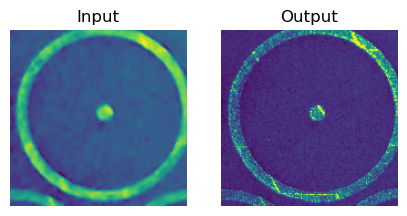

In [30]:
# for checking if dataloader works 

for i, data in enumerate(train_loader):
    lr_sample,hr_sample = data
    print(f"Shape of high resolution images : {hr_sample.shape}")
    print(f"Shape of low resolution images : {lr_sample.shape}")
    break
# print(hr_sample.type())
print("Number of images loaded :", len(train_dataset))
print("Number of batches in the dataloader :",len(train_loader))

# convert tensor to numpy and reshape it to 2D
input_img = (lr_sample[-1,:,:].cpu().detach().numpy()).reshape((160,160))
output_img = (hr_sample[-1,:,:].cpu().detach().numpy()).reshape((160,160))

# visualize
fig = plt.figure(figsize=(5, 5))
row = 1
col = 2

fig.add_subplot(row,col, 1)
plt.imshow(input_img)
plt.axis('off')
plt.title("Input")

fig.add_subplot(row,col, 2)
plt.imshow(output_img)
plt.axis('off')
plt.title("Output")


SR-DNS MODEL 


In [6]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_put, out_size, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) //2  # trying to keep the output dimensions same as input dimensions [Note: stride should be 1]
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_put, out_size, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_size),
            nn.LeakyReLU(inplace=True)
        )

In [7]:
#inverse residual block of mobilenet. (uses point wise convolution to narrow>wide>narrow and then add residual connection)
class inverted_residual(nn.Module):
    def __init__(self, input_size, output_size, stride, expand_ratio):
        super(inverted_residual,self).__init__()
        self.stride = stride
        self.input_size = input_size
        self.output_size = output_size
        expand_dim = int(round(input_size*expand_ratio)) # dimension for getting wider channel

        # conditions for residual block
        if input_size == output_size and expand_ratio != 1:
            self.residual = True
        else : self.residual = False

        #network
        self.layers = nn.Sequential(ConvBNReLU(self.input_size, expand_dim, kernel_size =1), #pointwise convolusion for expanding
                  ConvBNReLU(expand_dim, expand_dim, kernel_size =3, stride = stride, groups = expand_dim), #depthwise convolusion for same size and each input channel has its own filter (groups = input channel)
                  nn.Conv2d(expand_dim, output_size, stride= 1, kernel_size=1, bias=False), # pointwise convolusion for norrowing
                  nn.BatchNorm2d(output_size)
                  )
        
    def forward(self,x):
        if self.residual:
            return x + self.layers(x)
        else : 
            return x

In [8]:
class SRDnet(nn.Module):
    def __init__(self,lr_dim,hr_dim):
        super(SRDnet,self).__init__()

        # new dimension after convolution [ (W-F+2P)//S + 1 ]


        self.unet1= nn.Sequential(nn.Conv2d(in_channels=lr_dim,out_channels=32,kernel_size=4, stride=2, padding =1),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU()
                                    )
        self.unet2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4, stride=2, padding =1),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU()
                                    )
        self.unet3 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4, stride=2, padding =1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU()
                                    )
        
        self.bottle_neck1= nn.Sequential(inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6)
                                         )
        
        self.bottle_neck2= nn.Sequential(inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6),
                                         inverted_residual(input_size =128,output_size =128,stride=1,expand_ratio=6)
                                         )

        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(in_channels= 14, out_channels= hr_dim, kernel_size = 3, stride=1, padding=1),  
                                     nn.Tanh() 
                                     )
        
        self.unet_back1 = nn.Sequential(nn.PixelShuffle(2),
                                       nn.BatchNorm2d(32), # removed in the original code
                                       nn.LeakyReLU() # removed in the original code
                                       )
        self.unet_back2 = nn.Sequential(nn.PixelShuffle(2),
                                       nn.BatchNorm2d(24), # removed in the original code
                                       nn.LeakyReLU() # removed in the original code
                                       )
        self.unet_back3 = nn.Sequential(nn.PixelShuffle(2),
                                       nn.BatchNorm2d(14), # removed in the original code
                                       nn.LeakyReLU() # removed in the original code
                                       )
        self.unet_back4 = nn.Sequential(nn.PixelShuffle(2),
                                       nn.BatchNorm2d(7), # removed in the original code
                                       nn.LeakyReLU() # removed in the original code
                                       )
        
    def forward(self,x):

        # U_NET
        out = self.unet1(x) 
        res1 = out                      # residual 1 (64x64x32)
        out = self.unet2(out)
        res2 = out                      # residual 2 (32x32x64)
        out = self.unet3(out)
        res3 = out                      # residual 3 (16x16x128)    
        # print('shape before bottleneck',out.shape)
        #  MOBILE_NET
        out= self.bottle_neck1(out)
        out = torch.add(res3,out)       # skip connection
        res4= out                       # residual 4 (16x16x128)
        out = self.bottle_neck2(out)               
        out = torch.add(res4,out)       # skip connection
        # print('shape after bottle neck',out.shape)
        #U_NET
        out = self.unet_back1(out)       # (32x32x32)
        out = torch.cat((out,res2),1)       # concatenation 1 (32x32x96)  Note dim =1 for concatenation as the shapes of the inputs are 4d (batch X channels X width X height)
        # print("shape after unet back 1 ",out.shape)
        out = self.unet_back2(out)       # (64x64x24)
        out = torch.cat((out,res1),1)       # concatenation 2 (64x64x56)
        # print("shape after unet back 2 ",out.shape)
        out = self.unet_back3(out)         # 128x128x14
        out =  self.deconv1(out)           # 128x128x1
        # print("shape after deconv back 2 ",out.shape)
        return out


SANITY CHECK FOR MODEL

In [9]:
sample_input = lr_sample
batch_size,lr_dim,hr_dim = sample_input.shape
model = SRDnet(1,1).to(device)
# model = Mobile_UNet().to(device)
summary(model, (sample_input.unsqueeze(1)).to(device))
print((sample_input.unsqueeze(1)).shape)
pred = model(sample_input.unsqueeze(1))
print(pred.shape)

                                               Kernel Shape  \
Layer                                                         
0_unet1.Conv2d_0                              [1, 32, 4, 4]   
1_unet1.BatchNorm2d_1                                  [32]   
2_unet1.LeakyReLU_2                                       -   
3_unet2.Conv2d_0                             [32, 64, 4, 4]   
4_unet2.BatchNorm2d_1                                  [64]   
5_unet2.LeakyReLU_2                                       -   
6_unet3.Conv2d_0                            [64, 128, 4, 4]   
7_unet3.BatchNorm2d_1                                 [128]   
8_unet3.LeakyReLU_2                                       -   
9_bottle_neck1.0.layers.0.Conv2d_0         [128, 768, 1, 1]   
10_bottle_neck1.0.layers.0.BatchNorm2d_1              [768]   
11_bottle_neck1.0.layers.0.LeakyReLU_2                    -   
12_bottle_neck1.0.layers.1.Conv2d_0          [1, 768, 3, 3]   
13_bottle_neck1.0.layers.1.BatchNorm2d_1              [

/home/smash/miniconda3/envs/smash/lib/python3.11/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


DEFINING TRAINING PARAMETERS  (LOSS , OPTIMIZER, SCHEDULER)

In [25]:
# loss function for backpropagation
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
# optimizer for gradient descent
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, foreach=None, maximize=False, capturable=False, differentiable=False, fused=None)
# scheduler for learning rate
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08, verbose=False)
# mixed precision (makes training faster)
scaler = torch.cuda.amp.GradScaler()

#clear cache data
print("cache cleared :")
torch.cuda.empty_cache()
gc.collect()

cache cleared :


1301

TRAINING MODEL

In [22]:
# peak signal to noise ratio (METRIC FOR EVALUATION)
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(1, 160, 160)
    return x

def PSNR(op, t,):
    batch_size = op.shape[0]
    psnr = sum([peak_signal_noise_ratio(to_img(op[i]).cpu().detach().numpy(), to_img(t[i]).cpu().detach().numpy()) for i in range(op.shape[0])])/batch_size
    #print(psnr.size())
    return psnr 

def SSIM(op, t):
    batch_size = op.shape[0]
    ssim = sum([structural_similarity(np.squeeze(to_img(op[i]).cpu().detach().numpy().transpose(1,2,0),2), np.squeeze(to_img(t[i]).cpu().detach().numpy().transpose(1,2,0),2),
                multichannel=False, data_range= (np.squeeze(to_img(op[i]).cpu().detach().numpy().transpose(1,2,0),2).max() - np.squeeze(to_img(op[i]).cpu().detach().numpy().transpose(1,2,0),2).min())) for i in range(op.shape[0])])/batch_size
    return ssim

# for visualizing images at each epoch
def visualize_image(lr, groundtruth, pred, save = False):
    fig = plt.figure(figsize=(10, 7))
    row = 1
    col=3 
    
    fig.add_subplot(row,col, 1)
    plt.imshow(lr)
    plt.axis('off')
    plt.title("Input")

    fig.add_subplot(row,col, 2)
    plt.imshow(groundtruth)
    plt.axis('off')
    plt.title("Ground truth")

    fig.add_subplot(row,col, 3)
    plt.imshow(pred)
    plt.axis('off')
    plt.title("Prediction")


In [23]:
def train(model, dataloader, optimizer, loss):
    model= torch.nn.DataParallel(model,device_ids=[0,1,2,3,4,5,6,7])
    model.train()
    tloss = 0
    avg_psnr = 0
    avg_psnr_lr = 0
    avg_ssim = 0
    avg_ssim_lr = 0
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (lr,hr) in enumerate(dataloader):

        # initialize gradients to zero
        optimizer.zero_grad()
        # move the data to GPU
        hr = hr.to(device)
        lr = lr.to(device)
        # change 3d tensor (batch_size,height,width) to 4d tensor (batch_size,1,height,width)
        lr = lr.unsqueeze(1)
        hr= hr.unsqueeze(1)
        
        with torch.cuda.amp.autocast(dtype=torch.float16):
            # forward propagation
            pred  = model(lr)
            #loss calculation
            loss    = criterion(pred,hr)
            #metri calculation
            psnr    = PSNR(pred,hr)
            psnr_lr = PSNR(lr,hr)
            ssim    = SSIM(pred,hr)
            ssim_lr = SSIM(lr,hr)
        # backpropagation
        scaler.scale(loss).backward()
        #gradient descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        avg_psnr += psnr
        avg_psnr_lr += psnr_lr
        avg_ssim += ssim
        avg_ssim_lr +=ssim_lr

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))))
        batch_bar.update()

        torch.cuda.empty_cache()

    batch_bar.close()

    tloss   /= len(dataloader)
    avg_psnr /= len(dataloader)
    avg_psnr_lr /= len(dataloader)
    avg_ssim /= len(dataloader)
    avg_ssim_lr /= len(dataloader)

    metrics = [avg_psnr, avg_psnr_lr, avg_ssim, avg_ssim_lr]
    
    return tloss, metrics, lr, hr, pred  # taking input, ground truth and prediction for visualizing how model is performing


WANDB=True


In [ ]:
wandb.login(key="your wandb key")
if WANDB:
    wandb.init(
        id = "MSE_const_lr_0.01",
        project = "super_resolution_project",
    )
    


In [15]:
# save model weights and hyperparameters
def save_model(model, optimizer,  epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
        #  'scheduler_state_dict'     : scheduler.state_dict(),
         'epoch'                    : epoch},
         path
    )

In [ ]:
epoch_total = 300
figures = []
for epoch in range(0,epoch_total):

    print("\nEpoch {}/{}".format(epoch+1, epoch_total))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, metrics, lr, hr, pred  = train(model, train_loader, optimizer, criterion)
    loss_lr         = criterion(lr,hr)

    lr = (lr[-1,:,:,:].cpu().detach().numpy()).reshape((160,160))
    hr = (hr[-1,:,:,:].cpu().detach().numpy()).reshape((160,160))
    pred = (pred[-1,:,:,:].cpu().detach().numpy()).reshape((160,160))
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))

    wandb.log({ 'train_loss': train_loss, 'lr': curr_lr,'PSNR':metrics[0],'SSIM':metrics[2]})

    # scheduler.step(train_loss)

    print(f"\t PSNR origianl : {metrics[1]} \t SSIM original : {metrics[3]}  \t loss original : {loss_lr}")

    print("epoch done")

    

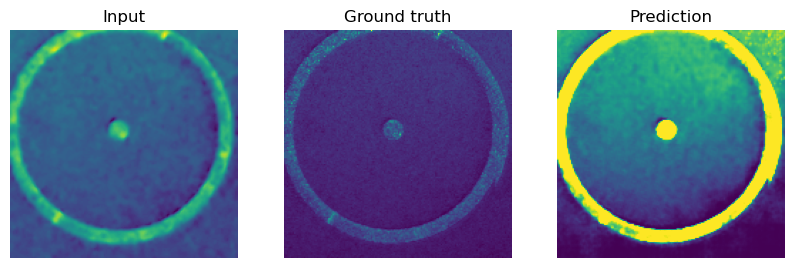

In [27]:
visualize_image(lr,hr,pred)

In [ ]:
# save_model(model, optimizer, scheduler, epoch, path="/home/smash/sumesh_data/LayerWiseSuperResolution-master/srdnet_sumesh")
wandb.finish()

In [29]:
save_model(model, optimizer, epoch, path="chkpnt_best.pth")